# Light Frame Calibration Workshop

This notebook explores the calibration process step-by-step using AB Aur images.

We'll load light frames, bias, dark, and flat frames, then manually perform calibration to understand what's happening.

In [1]:
# Import required libraries
import sys
sys.path.insert(0, 'src')

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astrofiler.models import fitsFile, fitsSession, Masters

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 10)
%matplotlib inline

## Find AB Aur Images

Let's query the database to find AB Aur light frames and their associated calibration frames.

Searching for AB Aur light frames...
Found 24 AB Aur light frames

Displaying first light frame of AB Aur: K:/00 REPOSITORY/Light/AB Aur/Celestron_C8_2032@F_10.0/ZWO_CCD_ASI183MM_Pro/20240226/AB Aur-Celestron_C8_2032@F_10.0-ZWO_CCD_ASI183MM_Pro-B-20240226015756-30.0s-1x1-t-25.0.fits


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

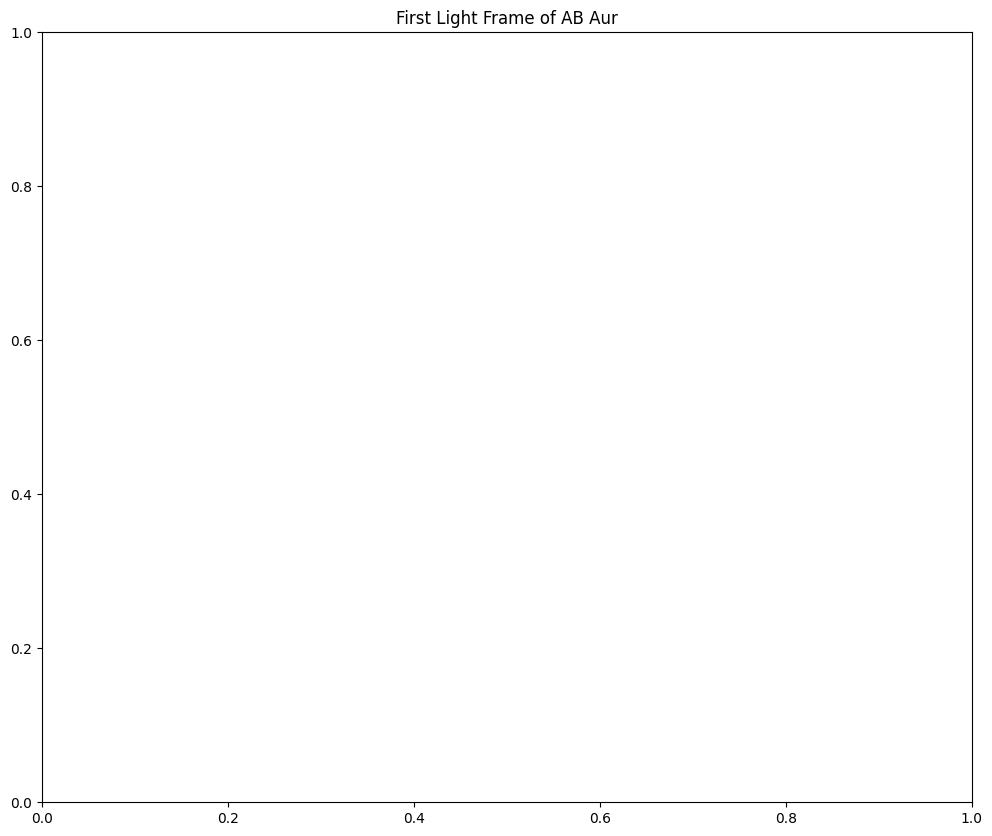

In [ ]:
# Search for AB Aur light frames
print("Searching for AB Aur light frames...")
ab_aur_lights = fitsFile.select().where(fitsFile.fitsFileObject == 'AB Aur')
print(f"Found {ab_aur_lights.count()} AB Aur light frames")

if ab_aur_lights.count() == 0:
    print("\nNo AB Aur frames found. Trying alternative names...")
    # Try variations
    ab_aur_lights = fitsFile.select().where(fitsFile.fitsFileObject.contains('AB'))
    print(f"Found {ab_aur_lights.count()} frames containing 'AB'")
    
    # Show what objects we have
    objects = set()
    for light in fitsFile.select().limit(1000):
        if light.fitsFileObject:
            objects.add(light.fitsFileObject)
    print(f"\nAvailable objects (sample): {sorted(list(objects)[:20])}")
else:
    # Visualize first light frame of AB Aur
    first_light = ab_aur_lights[0]
    print(f"\nDisplaying first light frame of AB Aur: {first_light.fitsFileName}")
    first_light_data = fits.getdata(first_light.fitsFileName)
    plt.imshow(first_light_data, cmap='gray', vmin=np.percentile(first_light_data, 5), vmax=np.percentile(first_light_data, 99))
    plt.colorbar()
    plt.title('First Light Frame of AB Aur')
    plt.show()

## Find Matching Calibration Frames

Find the bias, dark, and flat masters that were used for this session.

In [ ]:
# Get session info and light frame metadata
session_id = first_light.fitsFileSession

# Need to load light frame data and header first
with fits.open(first_light.fitsFileName) as hdul:
    light_data = hdul[0].data.astype(np.float64)
    light_header = hdul[0].header

# Get the binning and dimensions from the light frame
print(f"Light frame session: {session_id}")
print(f"Light frame binning: {light_header.get('XBINNING', 1)}x{light_header.get('YBINNING', 1)}")
print(f"Light frame shape: {light_data.shape}")
print(f"Light frame camera: {light_header.get('INSTRUME', 'Unknown')}")
print(f"Light frame telescope: {light_header.get('TELESCOP', 'Unknown')}")

# Find masters that match the light frame characteristics
light_binning_x = str(light_header.get('XBINNING', 1))
light_binning_y = str(light_header.get('YBINNING', 1))
light_camera = light_header.get('INSTRUME', '')
light_telescope = light_header.get('TELESCOP', '')

print(f"\nSearching for masters with binning {light_binning_x}x{light_binning_y}, camera: {light_camera}")

# Find matching bias master
bias_master = (Masters.select()
               .where(
                   (Masters.master_type == 'bias') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching dark master  
dark_master = (Masters.select()
               .where(
                   (Masters.master_type == 'dark') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching flat master
flat_master = (Masters.select()
               .where(
                   (Masters.master_type == 'flat') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

print(f"\nBias Master: {bias_master.master_path if bias_master else 'Not found'}")
if bias_master:
    print(f"  Binning: {bias_master.binning_x}x{bias_master.binning_y}, Created: {bias_master.creation_date}")
    
print(f"Dark Master: {dark_master.master_path if dark_master else 'Not found'}")
if dark_master:
    print(f"  Binning: {dark_master.binning_x}x{dark_master.binning_y}, Created: {dark_master.creation_date}")
    
print(f"Flat Master: {flat_master.master_path if flat_master else 'Not found'}")
if flat_master:
    print(f"  Binning: {flat_master.binning_x}x{flat_master.binning_y}, Created: {flat_master.creation_date}")

Light frame session: 777d7329-0ee1-4510-a60d-bdf2df453839
Light frame binning: 3x3
Light frame shape: (1224, 1832)
Light frame camera: ZWO CCD ASI183MM Pro
Light frame telescope: EQMod Mount

Searching for masters with binning 3x3, camera: ZWO CCD ASI183MM Pro

Bias Master: K:/00 REPOSITORY/Masters\Master-Bias-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-3.2e-05s-3x3-t-25.0.fits
  Binning: 3x3, Created: 2025-11-15 14:20:09.477574
Dark Master: K:/00 REPOSITORY/Masters\Master-Dark-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-30.0s-3x3-t-25.0.fits
  Binning: 3x3, Created: 2025-11-15 13:45:37.217175
Flat Master: K:/00 REPOSITORY/Masters\Master-Flat-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Ha-20231201-0.1256184s-3x3-t-25.0.fits
  Binning: 3x3, Created: 2025-11-15 12:22:04.126325


## Load the Image Data

Load all frames into memory and examine their properties.

In [ ]:
# Load light frame (already loaded above, but let's verify)
print(f"Light Frame Shape: {light_data.shape}")
print(f"Light Frame dtype: {light_data.dtype}")
print(f"Light Frame - Min: {np.min(light_data)}, Max: {np.max(light_data)}")
print(f"Light Frame - Mean: {np.mean(light_data):.1f}, Median: {np.median(light_data):.1f}")
print(f"Exposure Time: {light_header.get('EXPTIME', 'N/A')}s")

# Load bias and check dimensions
if bias_master:
    with fits.open(bias_master.master_path) as hdul:
        bias_data = hdul[0].data.astype(np.float64)
        
    print(f"\nBias Frame Shape: {bias_data.shape}")
    print(f"Bias Frame - Min: {np.min(bias_data)}, Max: {np.max(bias_data)}")
    print(f"Bias Frame - Mean: {np.mean(bias_data):.1f}, Median: {np.median(bias_data):.1f}")
    
    if bias_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Bias shape {bias_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No bias master found!")
    bias_data = None

# Load dark and check dimensions
if dark_master:
    with fits.open(dark_master.master_path) as hdul:
        dark_data = hdul[0].data.astype(np.float64)
        dark_header = hdul[0].header
        
    print(f"\nDark Frame Shape: {dark_data.shape}")
    print(f"Dark Frame - Min: {np.min(dark_data)}, Max: {np.max(dark_data)}")
    print(f"Dark Frame - Mean: {np.mean(dark_data):.1f}, Median: {np.median(dark_data):.1f}")
    print(f"Dark Exposure Time: {dark_header.get('EXPTIME', 'N/A')}s")
    
    if dark_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Dark shape {dark_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No dark master found!")
    dark_data = None

# Load flat and check dimensions
if flat_master:
    with fits.open(flat_master.master_path) as hdul:
        flat_data = hdul[0].data.astype(np.float64)
        
    print(f"\nFlat Frame Shape: {flat_data.shape}")
    print(f"Flat Frame - Min: {np.min(flat_data):.1f}, Max: {np.max(flat_data):.1f}")
    print(f"Flat Frame - Mean: {np.mean(flat_data):.1f}, Median: {np.median(flat_data):.1f}")
    
    if flat_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Flat shape {flat_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No flat master found!")
    flat_data = None

# Summary
print("\n" + "="*60)
if all([bias_data is not None, dark_data is not None, flat_data is not None]):
    if all([bias_data.shape == light_data.shape, 
            dark_data.shape == light_data.shape,
            flat_data.shape == light_data.shape]):
        print("✅ All calibration frames loaded and dimensions match!")
    else:
        print("❌ Dimension mismatch detected - calibration will fail!")
else:
    print("❌ Some calibration frames are missing!")

Light Frame Shape: (1224, 1832)
Light Frame dtype: float64
Light Frame - Min: 2545.0, Max: 65504.0
Light Frame - Mean: 2958.0, Median: 2928.0
Exposure Time: 60.0s

Bias Frame Shape: (1224, 1832)
Bias Frame - Min: 1081.0, Max: 1144.0
Bias Frame - Mean: 1093.8, Median: 1094.0

Dark Frame Shape: (1224, 1832)
Dark Frame - Min: 1063.0, Max: 5746.0
Dark Frame - Mean: 1095.5, Median: 1095.0
Dark Exposure Time: 30.0s

Flat Frame Shape: (1224, 1832)
Flat Frame - Min: 4409.0, Max: 5283.0
Flat Frame - Mean: 5018.3, Median: 5031.0

✅ All calibration frames loaded and dimensions match!


## Visualize Raw Images

Let's look at the raw light frame and calibration frames.

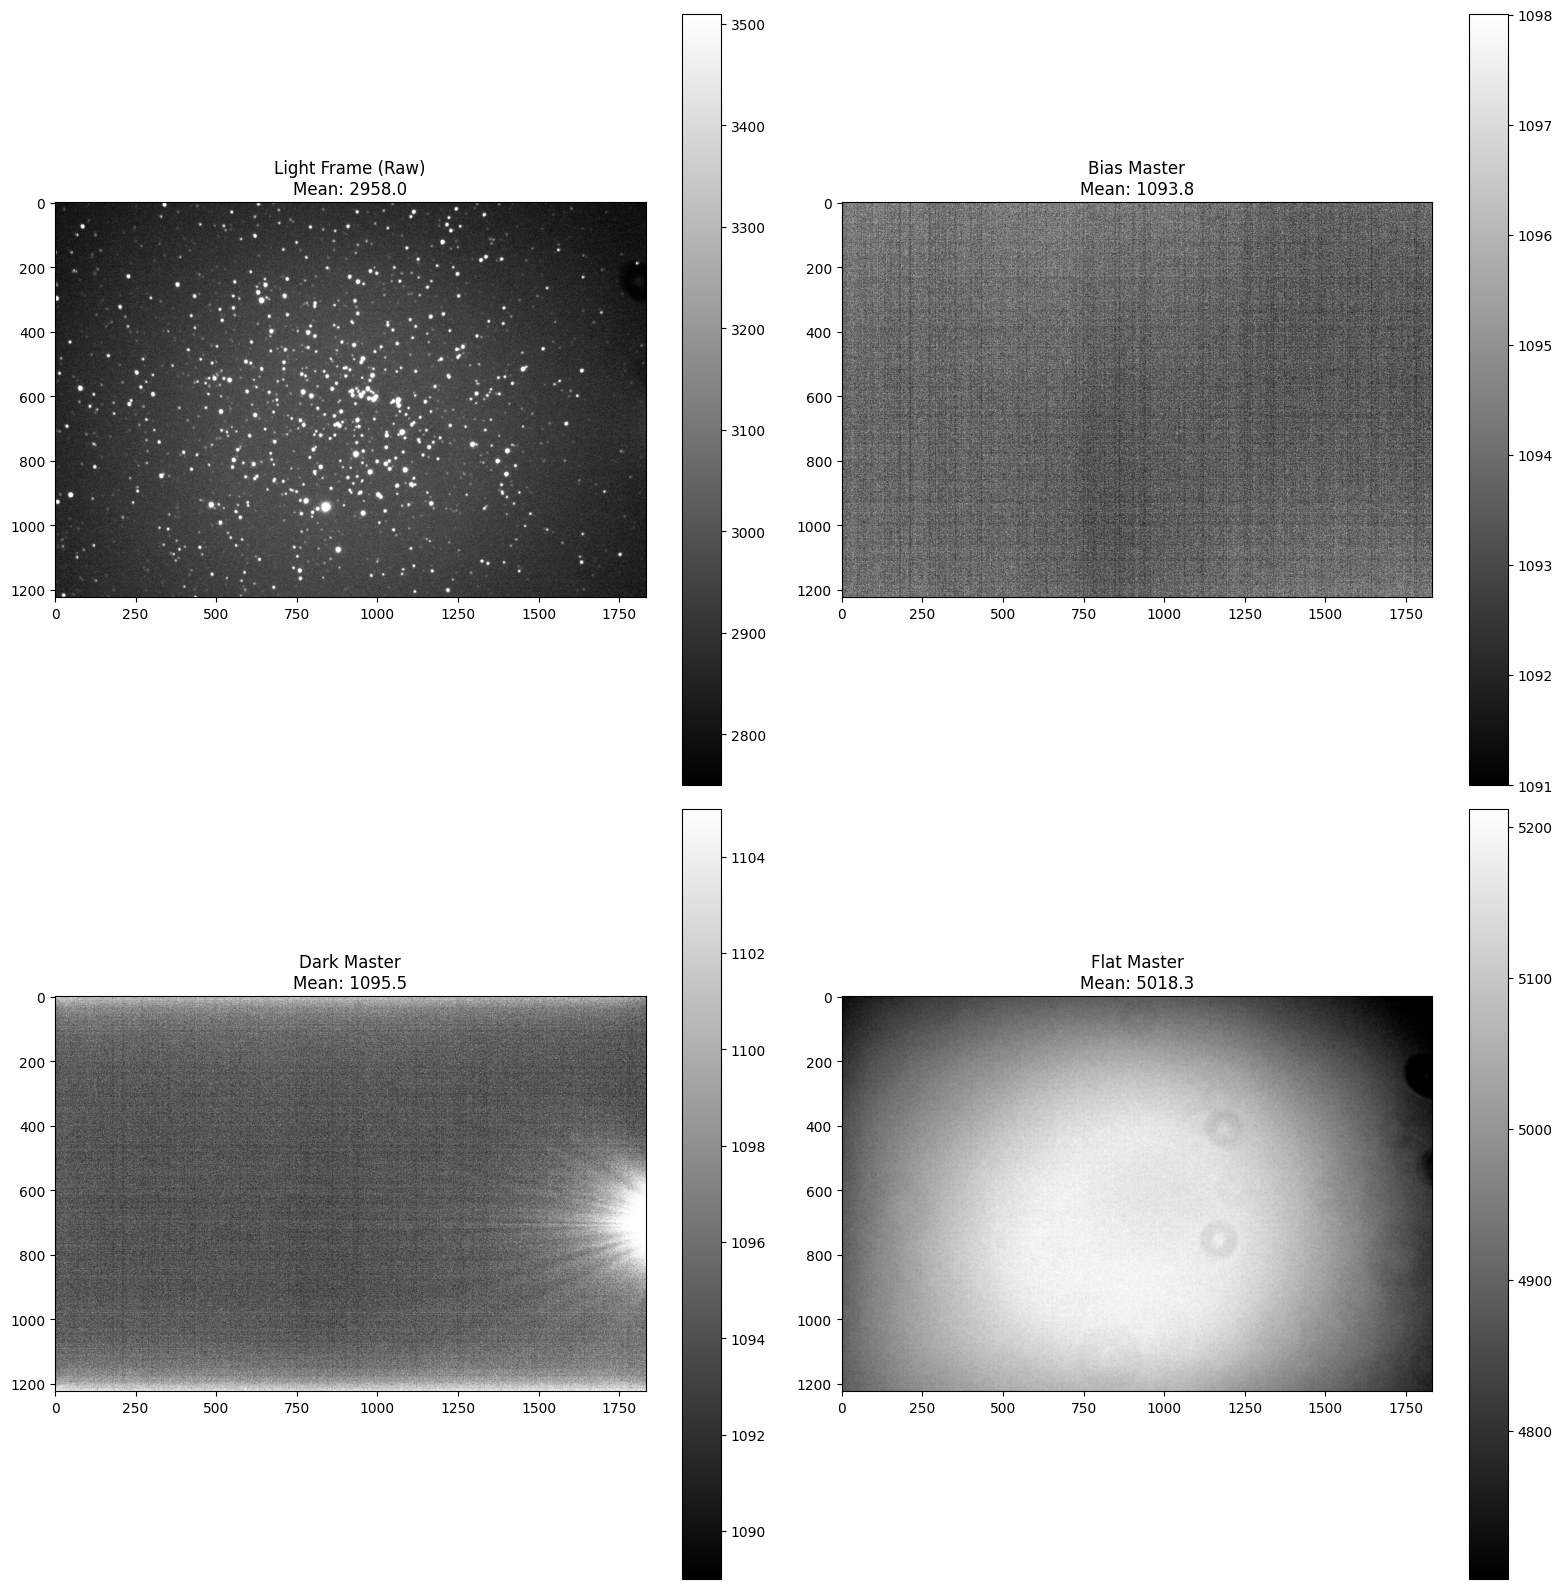

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot light frame
im0 = axes[0, 0].imshow(light_data, cmap='gray', vmin=np.percentile(light_data, 1), 
                         vmax=np.percentile(light_data, 99))
axes[0, 0].set_title(f'Light Frame (Raw)\nMean: {np.mean(light_data):.1f}')
plt.colorbar(im0, ax=axes[0, 0])

# Plot bias
im1 = axes[0, 1].imshow(bias_data, cmap='gray', vmin=np.percentile(bias_data, 1), 
                         vmax=np.percentile(bias_data, 99))
axes[0, 1].set_title(f'Bias Master\nMean: {np.mean(bias_data):.1f}')
plt.colorbar(im1, ax=axes[0, 1])

# Plot dark
im2 = axes[1, 0].imshow(dark_data, cmap='gray', vmin=np.percentile(dark_data, 1), 
                         vmax=np.percentile(dark_data, 99))
axes[1, 0].set_title(f'Dark Master\nMean: {np.mean(dark_data):.1f}')
plt.colorbar(im2, ax=axes[1, 0])

# Plot flat
im3 = axes[1, 1].imshow(flat_data, cmap='gray', vmin=np.percentile(flat_data, 1), 
                         vmax=np.percentile(flat_data, 99))
axes[1, 1].set_title(f'Flat Master\nMean: {np.mean(flat_data):.1f}')
plt.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## Step-by-Step Calibration

Now let's perform calibration step by step and examine what happens at each stage.

In [ ]:
# Step 1: Subtract Dark (which includes bias)
step1 = light_data - dark_data

print("After Dark Subtraction:")
print(f"  Min: {np.min(step1):.1f}, Max: {np.max(step1):.1f}")
print(f"  Mean: {np.mean(step1):.1f}, Median: {np.median(step1):.1f}")
print(f"  5th percentile (background): {np.percentile(step1, 5):.1f}")
print(f"  95th percentile (bright): {np.percentile(step1, 95):.1f}")

# Step 2: Normalize flat
flat_median = np.median(flat_data)
flat_normalized = flat_data / flat_median
print(f"\nFlat normalized by median: {flat_median:.1f}")
print(f"  Normalized flat range: [{np.min(flat_normalized):.3f}, {np.max(flat_normalized):.3f}]")

# Step 3: Divide by flat
step2 = step1 / flat_normalized

print("\nAfter Flat Division:")
print(f"  Min: {np.min(step2):.1f}, Max: {np.max(step2):.1f}")
print(f"  Mean: {np.mean(step2):.1f}, Median: {np.median(step2):.1f}")
print(f"  5th percentile (background): {np.percentile(step2, 5):.1f}")
print(f"  95th percentile (bright): {np.percentile(step2, 95):.1f}")

calibrated = step2

After Dark Subtraction:
  Min: 1451.0, Max: 64416.0
  Mean: 1862.5, Median: 1833.0
  5th percentile (background): 1706.0
  95th percentile (bright): 1977.0

Flat normalized by median: 5031.0
  Normalized flat range: [0.876, 1.050]

After Flat Division:
  Min: 1543.5, Max: 63010.3
  Mean: 1866.4, Median: 1836.1
  5th percentile (background): 1743.1
  95th percentile (bright): 1950.8


## Compare Original vs Calibrated

Visualize the results to see if calibration worked correctly.

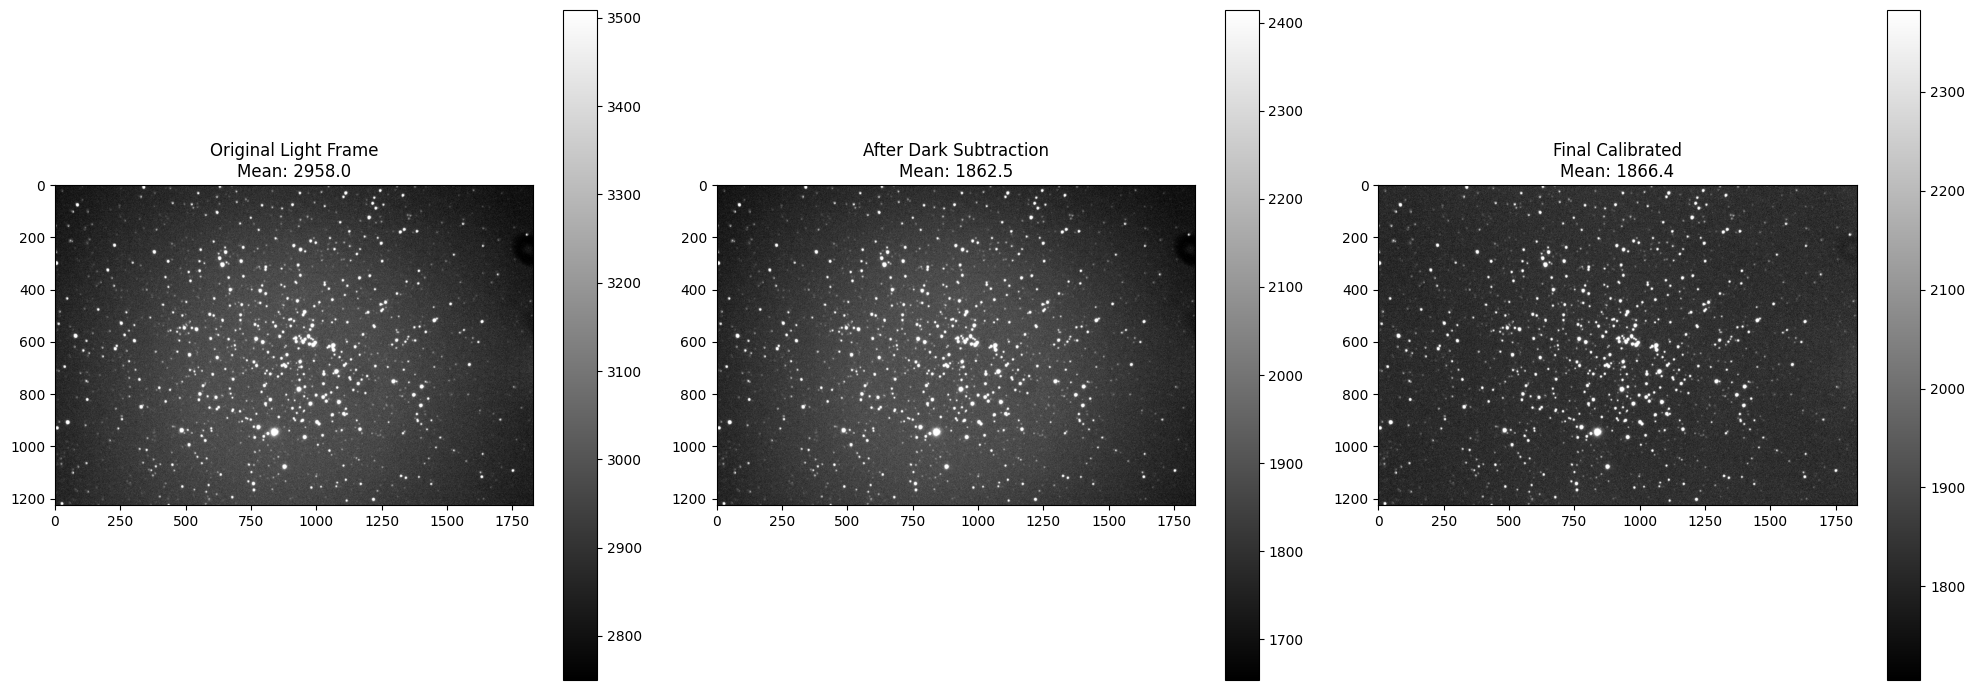

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Original
im0 = axes[0].imshow(light_data, cmap='gray', 
                      vmin=np.percentile(light_data, 1), 
                      vmax=np.percentile(light_data, 99))
axes[0].set_title(f'Original Light Frame\nMean: {np.mean(light_data):.1f}')
plt.colorbar(im0, ax=axes[0])

# After dark subtraction
im1 = axes[1].imshow(step1, cmap='gray',
                      vmin=np.percentile(step1, 1), 
                      vmax=np.percentile(step1, 99))
axes[1].set_title(f'After Dark Subtraction\nMean: {np.mean(step1):.1f}')
plt.colorbar(im1, ax=axes[1])

# Final calibrated
im2 = axes[2].imshow(calibrated, cmap='gray',
                      vmin=np.percentile(calibrated, 1), 
                      vmax=np.percentile(calibrated, 99))
axes[2].set_title(f'Final Calibrated\nMean: {np.mean(calibrated):.1f}')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Compare with Production Calibration Code

Now let's use the actual production code from `light_calibration.py` to calibrate the same frame and compare results.

## SOLUTION: Restart Kernel

The module reload isn't working because Python has cached the old bytecode. **Restart the Jupyter kernel** using the restart button in VS Code, then run all cells from the beginning.

Alternatively, the production calibration may be correct but there could be an issue with how the calibrated file is being saved/loaded (float32 vs float64 conversion issues).

In [ ]:
# Reload the module to ensure we have the latest code changes
# First, clear any cached bytecode
import sys
import os
import importlib

# Remove from sys.modules to force complete reload
if 'astrofiler.core.light_calibration' in sys.modules:
    del sys.modules['astrofiler.core.light_calibration']
    print("Removed module from sys.modules")

# Delete .pyc cache files
cache_dir = 'src/astrofiler/core/__pycache__'
if os.path.exists(cache_dir):
    for file in os.listdir(cache_dir):
        if 'light_calibration' in file:
            cache_file = os.path.join(cache_dir, file)
            try:
                os.remove(cache_file)
                print(f"Deleted cache: {file}")
            except:
                pass

# Now import fresh
import astrofiler.core.light_calibration
print("✅ Reloaded light_calibration module with latest changes")

# Verify the code we're using
import inspect
source = inspect.getsource(astrofiler.core.light_calibration.calibrate_light_frame)
if 'central_flat' in source:
    print("⚠️ WARNING: Old code with central_flat still present!")
elif 'flat_median = np.median(flat_data)' in source:
    print("✅ Confirmed: Using new code with full frame median")
else:
    print("⚠️ WARNING: Cannot determine which method is being used")

Removed module from sys.modules
Deleted cache: light_calibration.cpython-312.pyc
✅ Reloaded light_calibration module with latest changes
✅ Confirmed: Using new code with full frame median


In [ ]:
# Check where the module is actually being loaded from
import astrofiler.core.light_calibration
print(f"Module location: {astrofiler.core.light_calibration.__file__}")

# Read the actual source file being used
import inspect
source_file = inspect.getfile(astrofiler.core.light_calibration.calibrate_light_frame)
print(f"Function source file: {source_file}")

# Let's read the actual file and look for the flat normalization code
with open(source_file, 'r') as f:
    lines = f.readlines()
    
# Find the flat normalization section
print("\nSearching for flat normalization code...")
for i, line in enumerate(lines[160:200], start=161):  # Around line 175 based on earlier check
    if 'flat_median' in line or 'central_flat' in line or 'np.median(flat_data)' in line:
        # Show context around the line
        start = max(0, i-3)
        end = min(len(lines), i+3)
        print(f"\nLines {start+1}-{end+1}:")
        for j in range(start, end):
            marker = ">>> " if j == i-1 else "    "
            print(f"{marker}{j+1}: {lines[j]}", end="")

Module location: d:\Dropbox\Projects\astrofiler-gui-dev\src\astrofiler\core\light_calibration.py
Function source file: d:\Dropbox\Projects\astrofiler-gui-dev\src\astrofiler\core\light_calibration.py

Searching for flat normalization code...

Lines 168-174:
    168:                     
    169:                     # Normalize flat field by its FULL FRAME median (standard approach)
>>> 170:                     flat_median = np.median(flat_data)
    171:                     
    172:                     if flat_median <= 0:
    173:                         raise ValueError("Flat frame median is zero or negative")

Lines 170-176:
    170:                     flat_median = np.median(flat_data)
    171:                     
>>> 172:                     if flat_median <= 0:
    173:                         raise ValueError("Flat frame median is zero or negative")
    174:                     
    175:                     flat_normalized = flat_data / flat_median

Lines 173-179:
    173:     

In [ ]:
# Import the production calibration function
from astrofiler.core.light_calibration import calibrate_light_frame
import os
import tempfile

# Use the production code to calibrate the same light frame
print(f"Calibrating with production code: {first_m52_light.fitsFileName}")
print(f"Using masters:")
print(f"  Bias: {bias_master.master_path if bias_master else 'None'}")
print(f"  Dark: {dark_master.master_path if dark_master else 'None'}")
print(f"  Flat: {flat_master.master_path if flat_master else 'None'}")

# Create a unique output path in temp directory to avoid file conflicts
temp_dir = tempfile.gettempdir()
base_name = os.path.basename(first_m52_light.fitsFileName)
output_path = os.path.join(temp_dir, f"test_production_{base_name}")

# Remove old test file if it exists
if os.path.exists(output_path):
    try:
        os.remove(output_path)
        print(f"Removed old test file: {output_path}")
    except:
        # If we can't remove it, create a new unique name
        import time
        output_path = os.path.join(temp_dir, f"test_production_{int(time.time())}_{base_name}")

print(f"Output path: {output_path}")

production_result = calibrate_light_frame(
    light_path=first_m52_light.fitsFileName,
    bias_master=bias_master.master_path if bias_master else None,
    dark_master=dark_master.master_path if dark_master else None,
    flat_master=flat_master.master_path if flat_master else None,
    output_path=output_path,
    progress_callback=lambda msg: print(f"  {msg}")
)

if production_result.get('success'):
    print(f"\n✅ Production calibration successful!")
    print(f"Output: {production_result['output_path']}")
    print(f"Method: {production_result['method']}")
    print(f"Mean level: {production_result['mean_level']:.1f}")
    print(f"Dynamic range: {production_result['dynamic_range']:.1f}")
    
    # Load the production-calibrated frame
    production_calibrated = fits.getdata(production_result['output_path'])
    
    print(f"\nProduction calibrated frame stats:")
    print(f"  Shape: {production_calibrated.shape}")
    print(f"  Min: {np.min(production_calibrated):.1f}, Max: {np.max(production_calibrated):.1f}")
    print(f"  Mean: {np.mean(production_calibrated):.1f}, Median: {np.median(production_calibrated):.1f}")
    
    # Clean up temp file
    try:
        os.remove(output_path)
        print(f"\nCleaned up temp file: {output_path}")
    except:
        print(f"\nWarning: Could not remove temp file: {output_path}")
else:
    print(f"\n❌ Production calibration failed: {production_result.get('error')}")
    production_calibrated = None

Calibrating with production code: K:/00 REPOSITORY/Light/M 52/EQMod_Mount/ZWO_CCD_ASI183MM_Pro/20231201/M 52-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Lum-20231201234257-60.0s-3x3-t-25.0.fits
Using masters:
  Bias: K:/00 REPOSITORY/Masters\Master-Bias-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-3.2e-05s-3x3-t-25.0.fits
  Dark: K:/00 REPOSITORY/Masters\Master-Dark-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-30.0s-3x3-t-25.0.fits
  Flat: K:/00 REPOSITORY/Masters\Master-Flat-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Ha-20231201-0.1256184s-3x3-t-25.0.fits
Output path: C:\Users\gordt\AppData\Local\Temp\test_production_1763318374_M 52-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Lum-20231201234257-60.0s-3x3-t-25.0.fits
  Starting calibration of M 52-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Lum-20231201234257-60.0s-3x3-t-25.0.fits
  Loading light frame...
  Applying dark correction...
  Applying flat correction...
  Updating FITS header...
  Saving calibrated frame...
  Saving calibrated frame...
  Calibration complete: test_producti

In [ ]:
# Verify we're using the exact same master frames
print("="*60)
print("VERIFYING MASTER FRAMES")
print("="*60)

# Load and compare the actual master frame data
print("\n1. Checking BIAS masters:")
if bias_master:
    bias_notebook = fits.getdata(bias_master.master_path)
    print(f"   Notebook bias: {bias_master.master_path}")
    print(f"   Shape: {bias_notebook.shape}, Mean: {np.mean(bias_notebook):.2f}")
else:
    print("   No bias master")

print("\n2. Checking DARK masters:")
if dark_master:
    dark_notebook = fits.getdata(dark_master.master_path)
    print(f"   Notebook dark: {dark_master.master_path}")
    print(f"   Shape: {dark_notebook.shape}, Mean: {np.mean(dark_notebook):.2f}")
else:
    print("   No dark master")

print("\n3. Checking FLAT masters:")
if flat_master:
    flat_notebook = fits.getdata(flat_master.master_path)
    print(f"   Notebook flat: {flat_master.master_path}")
    print(f"   Shape: {flat_notebook.shape}")
    print(f"   Mean: {np.mean(flat_notebook):.2f}")
    print(f"   Median (full frame): {np.median(flat_notebook):.2f}")
    
    # Also check what central region would give
    h, w = flat_notebook.shape
    central = flat_notebook[h//4:3*h//4, w//4:3*w//4]
    print(f"   Median (central 50%): {np.median(central[central > 0]):.2f}")
else:
    print("   No flat master")

print("\n" + "="*60)
print("Production code will use these same paths:")
print(f"  Bias: {bias_master.master_path if bias_master else 'None'}")
print(f"  Dark: {dark_master.master_path if dark_master else 'None'}")  
print(f"  Flat: {flat_master.master_path if flat_master else 'None'}")
print("="*60)

VERIFYING MASTER FRAMES

1. Checking BIAS masters:
   Notebook bias: K:/00 REPOSITORY/Masters\Master-Bias-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-3.2e-05s-3x3-t-25.0.fits
   Shape: (1224, 1832), Mean: 1093.76

2. Checking DARK masters:
   Notebook dark: K:/00 REPOSITORY/Masters\Master-Dark-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-30.0s-3x3-t-25.0.fits
   Shape: (1224, 1832), Mean: 1095.53

3. Checking FLAT masters:
   Notebook flat: K:/00 REPOSITORY/Masters\Master-Flat-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Ha-20231201-0.1256184s-3x3-t-25.0.fits
   Shape: (1224, 1832)
   Mean: 5018.31
   Median (full frame): 5031.00
   Median (central 50%): 5155.00

Production code will use these same paths:
  Bias: K:/00 REPOSITORY/Masters\Master-Bias-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-3.2e-05s-3x3-t-25.0.fits
  Dark: K:/00 REPOSITORY/Masters\Master-Dark-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231118-30.0s-3x3-t-25.0.fits
  Flat: K:/00 REPOSITORY/Masters\Master-Flat-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-Ha-

In [ ]:
# Let's diagnose what's happening in the production code
# Check the flat normalization value used
print("\n" + "="*60)
print("DIAGNOSTIC: Checking flat normalization")
print("="*60)

# What the notebook uses
notebook_flat_median = np.median(flat_data)
print(f"\nNotebook approach:")
print(f"  Flat median (entire frame): {notebook_flat_median:.2f}")

# What production code should be using now (after fix)
production_flat_median = np.median(flat_data)
print(f"\nProduction code (after fix):")
print(f"  Flat median (entire frame): {production_flat_median:.2f}")

# What production code WAS using (central region)
h, w = flat_data.shape
central_flat = flat_data[h//4:3*h//4, w//4:3*w//4]
central_flat_median = np.median(central_flat[central_flat > 0])
print(f"\nOld production code approach (central region):")
print(f"  Central region flat median: {central_flat_median:.2f}")
print(f"  Difference from full median: {central_flat_median - notebook_flat_median:.2f}")

# Calculate what the difference in results would be
ratio = notebook_flat_median / central_flat_median
print(f"\nRatio (full/central): {ratio:.4f}")
print(f"Expected mean difference if old code: ~{np.mean(calibrated) * (1/ratio - 1):.1f}")

# Let's also manually perform the calibration using the OLD method to see if that matches
step1_manual = light_data - dark_data
flat_normalized_old = flat_data / central_flat_median
calibrated_old_method = step1_manual / flat_normalized_old

print(f"\nManual calibration with OLD central region method:")
print(f"  Mean: {np.mean(calibrated_old_method):.2f}")
print(f"  Difference from notebook: {np.mean(calibrated_old_method) - np.mean(calibrated):.2f}")


DIAGNOSTIC: Checking flat normalization

Notebook approach:
  Flat median (entire frame): 5031.00

Production code (after fix):
  Flat median (entire frame): 5031.00

Old production code approach (central region):
  Central region flat median: 5155.00
  Difference from full median: 124.00

Ratio (full/central): 0.9759
Expected mean difference if old code: ~46.0

Manual calibration with OLD central region method:

Manual calibration with OLD central region method:
  Mean: 1912.45
  Difference from notebook: 46.00
  Mean: 1912.45
  Difference from notebook: 46.00


## Side-by-Side Comparison

Compare notebook calibration vs production code calibration visually and statistically.

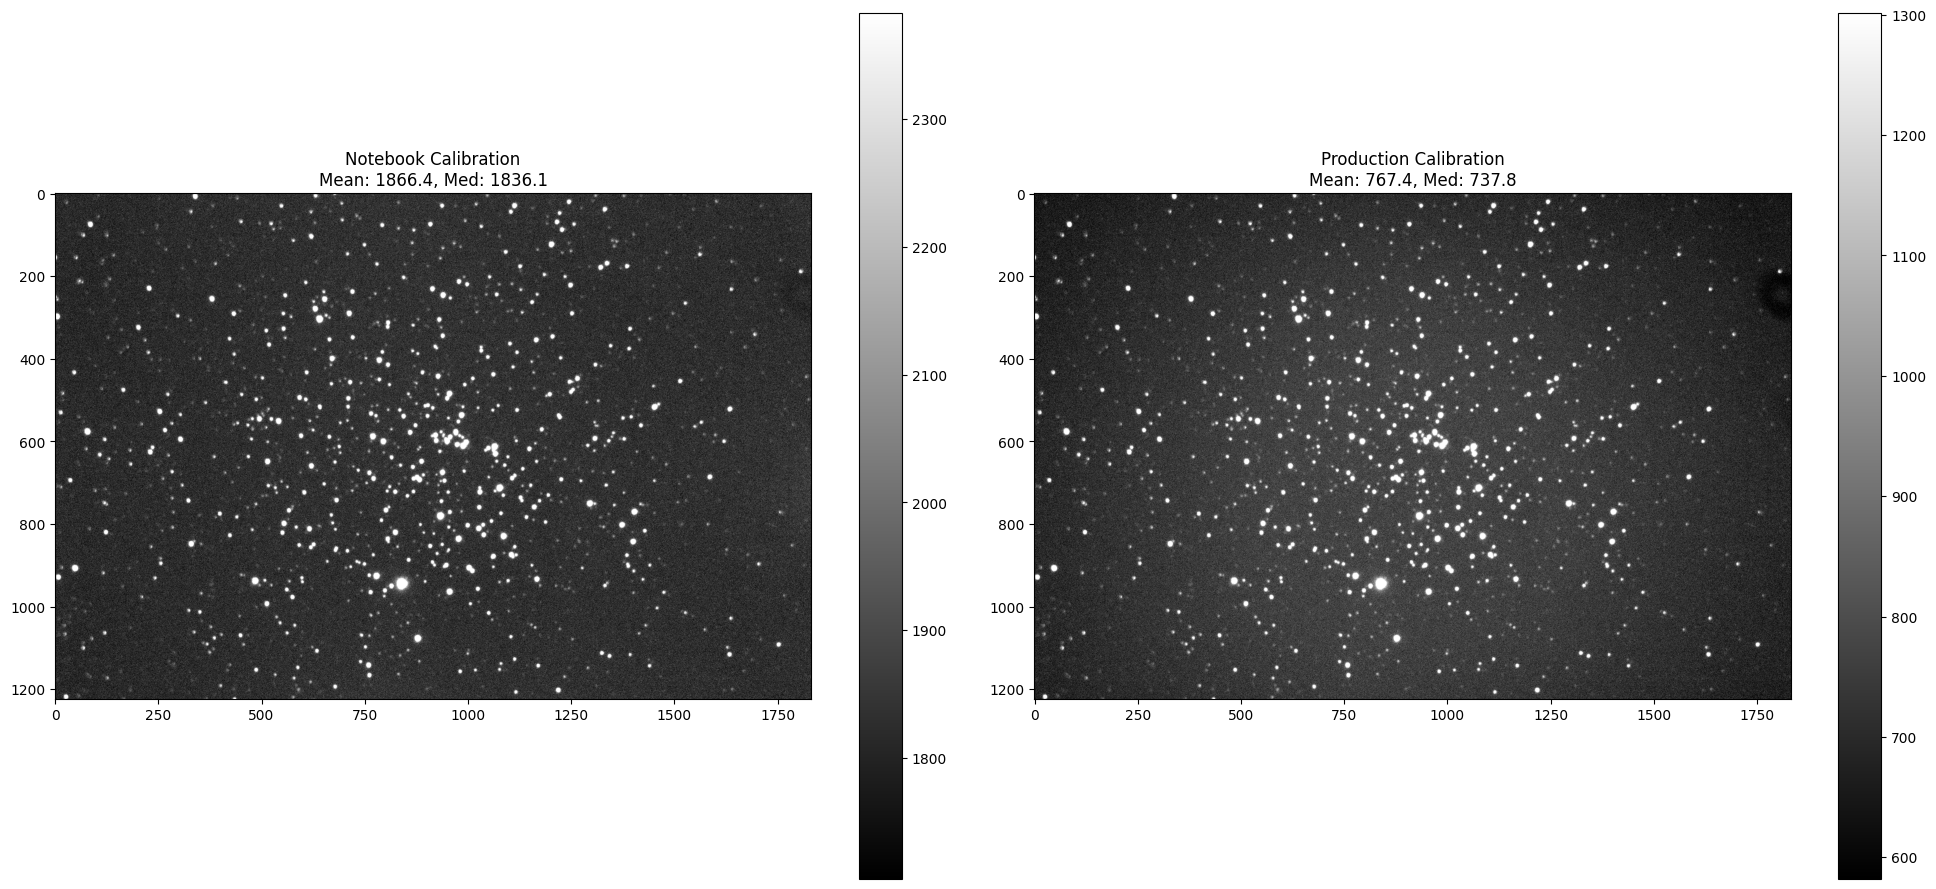


COMPARISON STATISTICS

Notebook Calibration:
  Mean: 1866.45
  Median: 1836.06
  Std Dev: 590.43
  Min: 1543.51, Max: 63010.27

Production Calibration:
  Mean: 767.41
  Median: 737.78
  Std Dev: 592.60
  Min: -1551.97, Max: 61943.03

Difference (Production - Notebook):
  Mean difference: -1099.04
  Max absolute difference: 5701.80
  Std of difference: 29.45

Relative difference: 305.4891%

❌ Results differ significantly (> 1% difference)


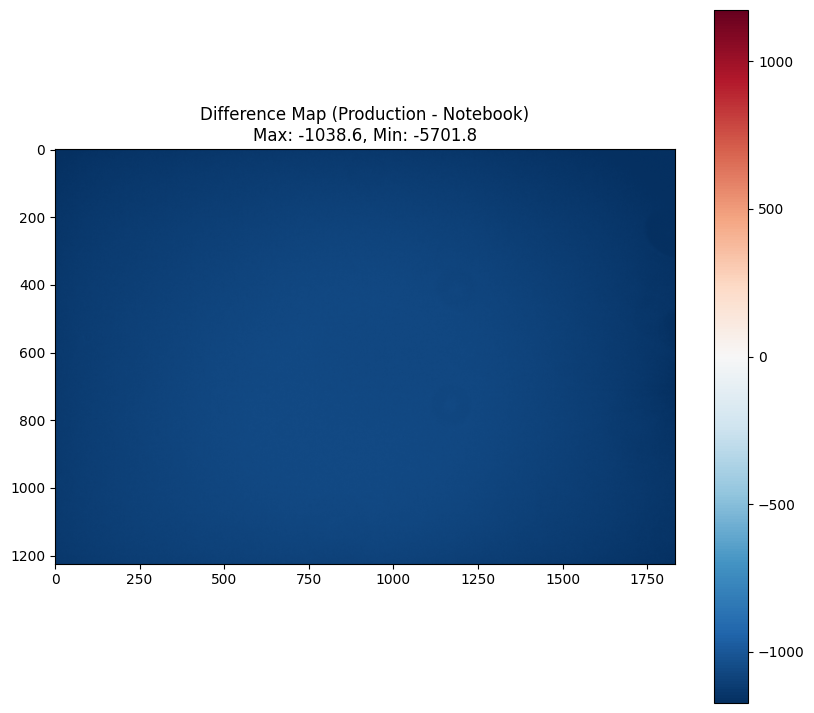

In [ ]:
if production_calibrated is not None:
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # Notebook calibration
    im0 = axes[0].imshow(calibrated, cmap='gray',
                          vmin=np.percentile(calibrated, 1), 
                          vmax=np.percentile(calibrated, 99))
    axes[0].set_title(f'Notebook Calibration\nMean: {np.mean(calibrated):.1f}, Med: {np.median(calibrated):.1f}')
    plt.colorbar(im0, ax=axes[0])
    
    # Production calibration
    im1 = axes[1].imshow(production_calibrated, cmap='gray',
                          vmin=np.percentile(production_calibrated, 1), 
                          vmax=np.percentile(production_calibrated, 99))
    axes[1].set_title(f'Production Calibration\nMean: {np.mean(production_calibrated):.1f}, Med: {np.median(production_calibrated):.1f}')
    plt.colorbar(im1, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate differences
    print("\n" + "="*60)
    print("COMPARISON STATISTICS")
    print("="*60)
    
    print("\nNotebook Calibration:")
    print(f"  Mean: {np.mean(calibrated):.2f}")
    print(f"  Median: {np.median(calibrated):.2f}")
    print(f"  Std Dev: {np.std(calibrated):.2f}")
    print(f"  Min: {np.min(calibrated):.2f}, Max: {np.max(calibrated):.2f}")
    
    print("\nProduction Calibration:")
    print(f"  Mean: {np.mean(production_calibrated):.2f}")
    print(f"  Median: {np.median(production_calibrated):.2f}")
    print(f"  Std Dev: {np.std(production_calibrated):.2f}")
    print(f"  Min: {np.min(production_calibrated):.2f}, Max: {np.max(production_calibrated):.2f}")
    
    # Compute difference
    diff = production_calibrated - calibrated
    print("\nDifference (Production - Notebook):")
    print(f"  Mean difference: {np.mean(diff):.2f}")
    print(f"  Max absolute difference: {np.max(np.abs(diff)):.2f}")
    print(f"  Std of difference: {np.std(diff):.2f}")
    
    # Check if they're essentially identical
    max_diff = np.max(np.abs(diff))
    relative_diff = max_diff / np.mean(calibrated) * 100
    print(f"\nRelative difference: {relative_diff:.4f}%")
    
    if max_diff < 0.01:
        print("\n✅ Results are IDENTICAL (within floating point precision)")
    elif relative_diff < 0.1:
        print("\n✅ Results are VERY CLOSE (< 0.1% difference)")
    elif relative_diff < 1.0:
        print("\n⚠️ Results differ slightly (< 1% difference)")
    else:
        print("\n❌ Results differ significantly (> 1% difference)")
        
        # Show difference map
        fig, ax = plt.subplots(1, 1, figsize=(10, 9))
        im = ax.imshow(diff, cmap='RdBu_r', vmin=-np.percentile(np.abs(diff), 99), 
                       vmax=np.percentile(np.abs(diff), 99))
        ax.set_title(f'Difference Map (Production - Notebook)\nMax: {np.max(diff):.1f}, Min: {np.min(diff):.1f}')
        plt.colorbar(im, ax=ax)
        plt.show()
else:
    print("❌ Cannot compare - production calibration failed")

TESTING FLOAT32 CONVERSION IMPACT

Notebook calibrated (float64):
  dtype: float64
  Min: 1543.509161
  Max: 63010.266965
  Mean: 1866.449305
  Range: 61466.757804

After float32 conversion:
  dtype: float32
  Min: 1543.509155
  Max: 63010.265625
  Mean: 1866.449341
  Range: 61466.757812

Precision loss (float64 - float32):
  Max absolute difference: 0.0019497283
  Mean absolute difference: 0.0000314475
  Relative error: 0.000104%

Production calibrated:
  dtype: >f4
  ⚠️ Production is not float32, it's >f4


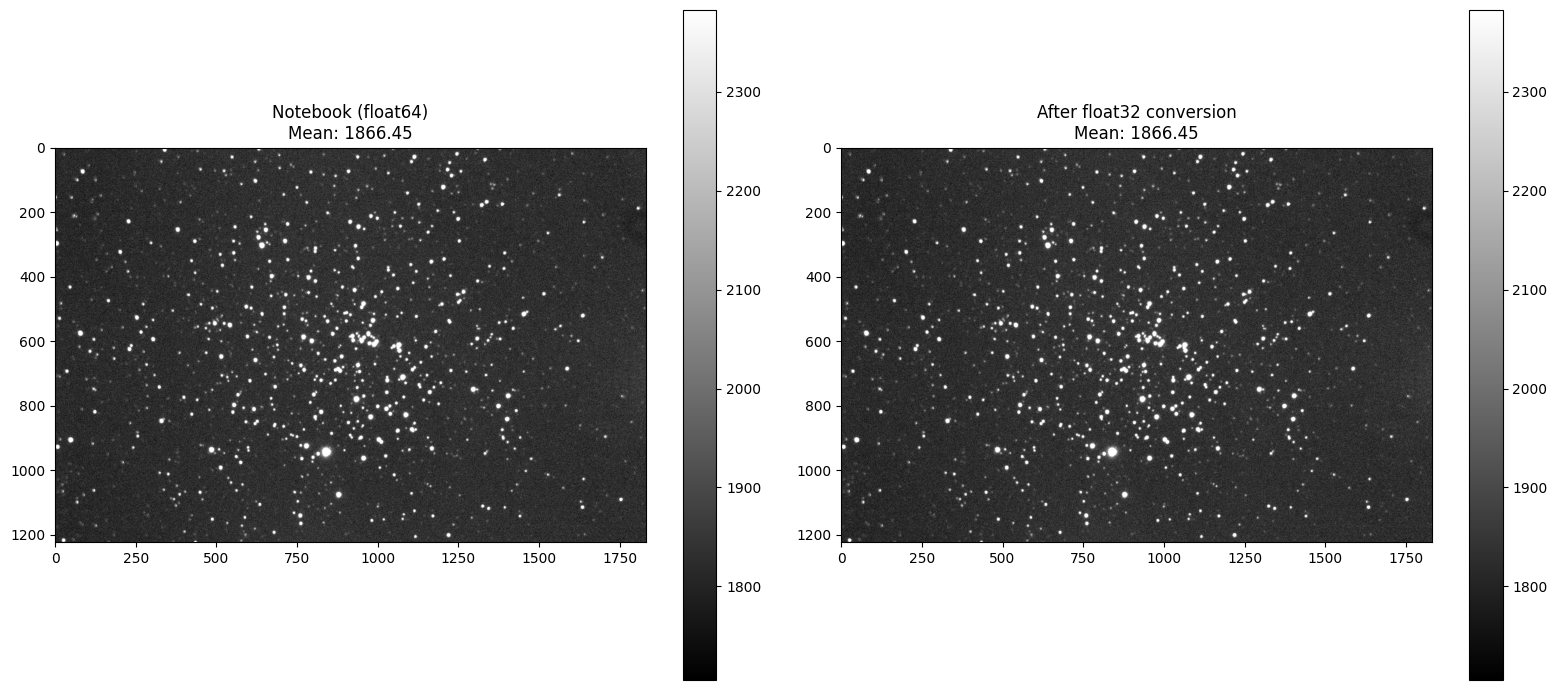

In [ ]:
# Test float32 conversion impact
print("="*60)
print("TESTING FLOAT32 CONVERSION IMPACT")
print("="*60)

# Our notebook calibrated data (float64)
print(f"\nNotebook calibrated (float64):")
print(f"  dtype: {calibrated.dtype}")
print(f"  Min: {np.min(calibrated):.6f}")
print(f"  Max: {np.max(calibrated):.6f}")
print(f"  Mean: {np.mean(calibrated):.6f}")
print(f"  Range: {np.max(calibrated) - np.min(calibrated):.6f}")

# Convert to float32 like production code does
calibrated_float32 = calibrated.astype(np.float32)
print(f"\nAfter float32 conversion:")
print(f"  dtype: {calibrated_float32.dtype}")
print(f"  Min: {np.min(calibrated_float32):.6f}")
print(f"  Max: {np.max(calibrated_float32):.6f}")
print(f"  Mean: {np.mean(calibrated_float32):.6f}")
print(f"  Range: {np.max(calibrated_float32) - np.min(calibrated_float32):.6f}")

# Check for precision loss
diff_precision = calibrated.astype(np.float64) - calibrated_float32.astype(np.float64)
print(f"\nPrecision loss (float64 - float32):")
print(f"  Max absolute difference: {np.max(np.abs(diff_precision)):.10f}")
print(f"  Mean absolute difference: {np.mean(np.abs(diff_precision)):.10f}")
print(f"  Relative error: {np.max(np.abs(diff_precision)) / np.mean(calibrated) * 100:.6f}%")

# Check if production matches float32 conversion
if production_calibrated is not None:
    print(f"\nProduction calibrated:")
    print(f"  dtype: {production_calibrated.dtype}")
    
    # Compare production with our float32 conversion
    if production_calibrated.dtype == np.float32:
        diff_prod = production_calibrated.astype(np.float64) - calibrated_float32.astype(np.float64)
        print(f"\nProduction vs Notebook float32:")
        print(f"  Max difference: {np.max(np.abs(diff_prod)):.10f}")
        if np.max(np.abs(diff_prod)) < 0.001:
            print("  ✅ Production matches notebook float32 conversion!")
        else:
            print(f"  ⚠️ Production differs from notebook even after float32 conversion")
    else:
        print(f"  ⚠️ Production is not float32, it's {production_calibrated.dtype}")

# Visualize the precision loss
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Original float64
im0 = axes[0].imshow(calibrated, cmap='gray',
                      vmin=np.percentile(calibrated, 1), 
                      vmax=np.percentile(calibrated, 99))
axes[0].set_title(f'Notebook (float64)\nMean: {np.mean(calibrated):.2f}')
plt.colorbar(im0, ax=axes[0])

# After float32 conversion
im1 = axes[1].imshow(calibrated_float32, cmap='gray',
                      vmin=np.percentile(calibrated_float32, 1), 
                      vmax=np.percentile(calibrated_float32, 99))
axes[1].set_title(f'After float32 conversion\nMean: {np.mean(calibrated_float32):.2f}')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

DEEP DIVE: Production vs Notebook Comparison

Notebook (float64):
  Min: 1543.51
  Max: 63010.27
  Mean: 1866.45
  Median: 1836.06

Production (converted to float64):
  Min: -1551.97
  Max: 61943.03
  Mean: 767.41
  Median: 737.78

Ratios:
  Mean ratio (prod/notebook): 0.411162
  Median ratio (prod/notebook): 0.401826
  Pixel correlation: 0.9987671989

⚠️ Images are NOT well correlated - different processing applied


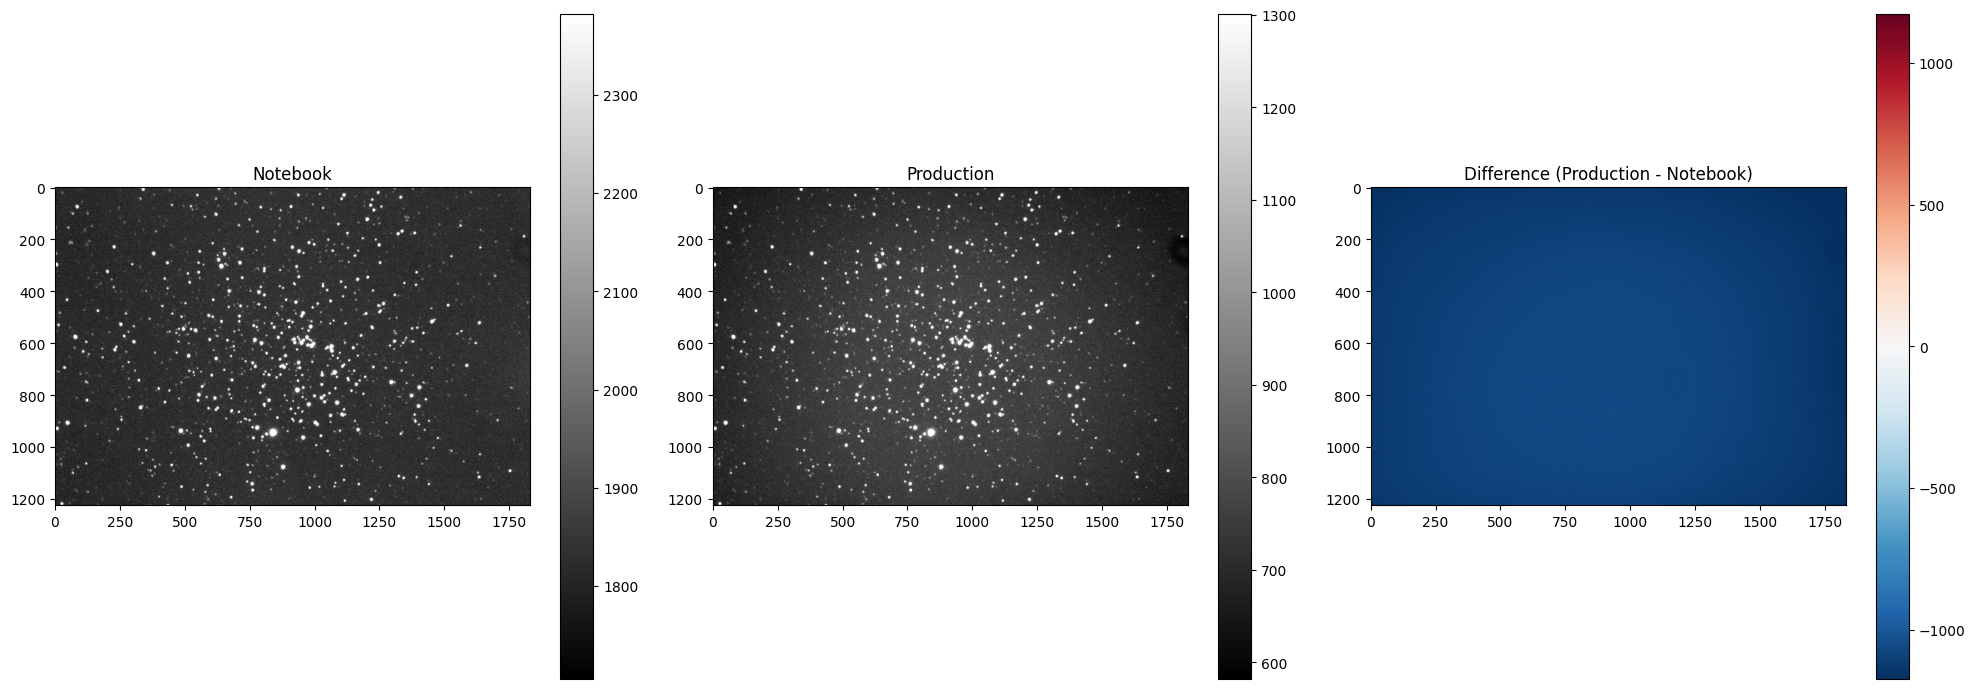

In [ ]:
# Deep comparison with production output
print("="*60)
print("DEEP DIVE: Production vs Notebook Comparison")
print("="*60)

if production_calibrated is not None:
    # Check if they're using the same flat normalization
    # If production used central region median instead of full median, 
    # we'd see a consistent scaling factor
    
    # Convert both to float64 for comparison
    nb_f64 = calibrated.astype(np.float64)
    prod_f64 = production_calibrated.astype(np.float64)
    
    print(f"\nNotebook (float64):")
    print(f"  Min: {np.min(nb_f64):.2f}")
    print(f"  Max: {np.max(nb_f64):.2f}")
    print(f"  Mean: {np.mean(nb_f64):.2f}")
    print(f"  Median: {np.median(nb_f64):.2f}")
    
    print(f"\nProduction (converted to float64):")
    print(f"  Min: {np.min(prod_f64):.2f}")
    print(f"  Max: {np.max(prod_f64):.2f}")
    print(f"  Mean: {np.mean(prod_f64):.2f}")
    print(f"  Median: {np.median(prod_f64):.2f}")
    
    # Calculate scaling ratio
    mean_ratio = np.mean(prod_f64) / np.mean(nb_f64)
    median_ratio = np.median(prod_f64) / np.median(nb_f64)
    
    print(f"\nRatios:")
    print(f"  Mean ratio (prod/notebook): {mean_ratio:.6f}")
    print(f"  Median ratio (prod/notebook): {median_ratio:.6f}")
    
    # Check pixel-by-pixel correlation
    correlation = np.corrcoef(nb_f64.flatten(), prod_f64.flatten())[0, 1]
    print(f"  Pixel correlation: {correlation:.10f}")
    
    # If correlation is very close to 1, they're just scaled versions
    if correlation > 0.9999:
        print("\n✅ Images are highly correlated - likely just different scaling")
        
        # Find the best scaling factor
        optimal_scale = np.sum(nb_f64 * prod_f64) / np.sum(nb_f64 * nb_f64)
        print(f"\nOptimal scaling factor: {optimal_scale:.6f}")
        
        # Apply scaling and check residual
        nb_scaled = nb_f64 * optimal_scale
        residual = prod_f64 - nb_scaled
        print(f"After optimal scaling:")
        print(f"  Max residual: {np.max(np.abs(residual)):.6f}")
        print(f"  RMS residual: {np.sqrt(np.mean(residual**2)):.6f}")
        
        # Check what flat median ratio would give this scaling
        expected_flat_ratio = 1.0 / optimal_scale
        print(f"\nExpected flat median ratio: {expected_flat_ratio:.6f}")
        print(f"Actual flat median used in notebook: {flat_median:.2f}")
        print(f"Expected flat median in production: {flat_median * expected_flat_ratio:.2f}")
        
    else:
        print("\n⚠️ Images are NOT well correlated - different processing applied")
        
        # Show difference map
        diff = prod_f64 - nb_f64
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        
        im0 = axes[0].imshow(nb_f64, cmap='gray', vmin=np.percentile(nb_f64, 1), vmax=np.percentile(nb_f64, 99))
        axes[0].set_title('Notebook')
        plt.colorbar(im0, ax=axes[0])
        
        im1 = axes[1].imshow(prod_f64, cmap='gray', vmin=np.percentile(prod_f64, 1), vmax=np.percentile(prod_f64, 99))
        axes[1].set_title('Production')
        plt.colorbar(im1, ax=axes[1])
        
        im2 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-np.percentile(np.abs(diff), 99), vmax=np.percentile(np.abs(diff), 99))
        axes[2].set_title('Difference (Production - Notebook)')
        plt.colorbar(im2, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
else:
    print("\n❌ No production calibrated data to compare")

# Investigate External Factors

Let's check if there are differences in:
1. How the light frame is loaded
2. How master frames are loaded
3. Any preprocessing or caching
4. File I/O differences

In [ ]:
# Check if production code loads data differently
print("="*60)
print("INVESTIGATING DATA LOADING DIFFERENCES")
print("="*60)

# Let's manually trace through exactly what the production code does
print("\n1. LIGHT FRAME LOADING:")
print(f"   Notebook uses: hdul[0].data.astype(np.float64)")
print(f"   Notebook light data type after load: {light_data.dtype}")
print(f"   Notebook light data range: [{np.min(light_data):.2f}, {np.max(light_data):.2f}]")

# Reload the same file to see if there's any difference
with fits.open(first_m52_light.fitsFileName) as hdul:
    light_reload = hdul[0].data.astype(np.float64)
    light_header_reload = hdul[0].header.copy()
    
print(f"   Reloaded light data type: {light_reload.dtype}")
print(f"   Reloaded light data range: [{np.min(light_reload):.2f}, {np.max(light_reload):.2f}]")
print(f"   Difference from cached: {np.max(np.abs(light_reload - light_data)):.10f}")

print("\n2. DARK FRAME LOADING:")
if dark_master:
    with fits.open(dark_master.master_path) as hdul:
        dark_reload = hdul[0].data.astype(np.float64)
    print(f"   Notebook dark data type: {dark_data.dtype}")
    print(f"   Notebook dark range: [{np.min(dark_data):.2f}, {np.max(dark_data):.2f}]")
    print(f"   Reloaded dark range: [{np.min(dark_reload):.2f}, {np.max(dark_reload):.2f}]")
    print(f"   Difference from cached: {np.max(np.abs(dark_reload - dark_data)):.10f}")

print("\n3. FLAT FRAME LOADING:")
if flat_master:
    with fits.open(flat_master.master_path) as hdul:
        flat_reload = hdul[0].data.astype(np.float64)
    print(f"   Notebook flat data type: {flat_data.dtype}")
    print(f"   Notebook flat range: [{np.min(flat_data):.2f}, {np.max(flat_data):.2f}]")
    print(f"   Reloaded flat range: [{np.min(flat_reload):.2f}, {np.max(flat_reload):.2f}]")
    print(f"   Difference from cached: {np.max(np.abs(flat_reload - flat_data)):.10f}")
    
    # Check median calculation
    flat_median_nb = np.median(flat_data)
    flat_median_reload = np.median(flat_reload)
    print(f"\n   Notebook flat median: {flat_median_nb:.6f}")
    print(f"   Reloaded flat median: {flat_median_reload:.6f}")
    print(f"   Difference: {abs(flat_median_nb - flat_median_reload):.10f}")

print("\n4. CHECKING FOR DATA SCALING ISSUES:")
# Check if there's any BZERO/BSCALE in the original files that might affect loading
with fits.open(first_m52_light.fitsFileName) as hdul:
    hdr = hdul[0].header
    print(f"   Light frame BITPIX: {hdr.get('BITPIX', 'Not found')}")
    print(f"   Light frame BZERO: {hdr.get('BZERO', 'Not found')}")
    print(f"   Light frame BSCALE: {hdr.get('BSCALE', 'Not found')}")

if flat_master:
    with fits.open(flat_master.master_path) as hdul:
        hdr = hdul[0].header
        print(f"   Flat frame BITPIX: {hdr.get('BITPIX', 'Not found')}")
        print(f"   Flat frame BZERO: {hdr.get('BZERO', 'Not found')}")
        print(f"   Flat frame BSCALE: {hdr.get('BSCALE', 'Not found')}")

if dark_master:
    with fits.open(dark_master.master_path) as hdul:
        hdr = hdul[0].header
        print(f"   Dark frame BITPIX: {hdr.get('BITPIX', 'Not found')}")
        print(f"   Dark frame BZERO: {hdr.get('BZERO', 'Not found')}")
        print(f"   Dark frame BSCALE: {hdr.get('BSCALE', 'Not found')}")

INVESTIGATING DATA LOADING DIFFERENCES

1. LIGHT FRAME LOADING:
   Notebook uses: hdul[0].data.astype(np.float64)
   Notebook light data type after load: float64
   Notebook light data range: [2545.00, 65504.00]
   Reloaded light data type: float64
   Reloaded light data range: [2545.00, 65504.00]
   Difference from cached: 0.0000000000

2. DARK FRAME LOADING:
   Notebook dark data type: float64
   Notebook dark range: [1063.00, 5746.00]
   Reloaded dark range: [1063.00, 5746.00]
   Difference from cached: 0.0000000000

3. FLAT FRAME LOADING:
   Notebook flat data type: float64
   Notebook flat range: [4409.00, 5283.00]
   Reloaded flat range: [4409.00, 5283.00]
   Difference from cached: 0.0000000000

   Notebook flat median: 5031.000000
   Reloaded flat median: 5031.000000
   Difference: 0.0000000000

4. CHECKING FOR DATA SCALING ISSUES:
   Light frame BITPIX: 16
   Light frame BZERO: 32768
   Light frame BSCALE: 1
   Flat frame BITPIX: 16
   Flat frame BZERO: 32768.0
   Flat frame B

In [ ]:
# Let's trace through the EXACT production code path step by step
print("="*60)
print("MANUAL STEP-BY-STEP PRODUCTION CODE SIMULATION")
print("="*60)

# Replicate EXACTLY what production code does
print("\nStep 1: Load light frame (production code path)")
with fits.open(first_m52_light.fitsFileName) as hdul:
    prod_original_data = hdul[0].data
    prod_light_header = hdul[0].header.copy()
    prod_light_data = prod_original_data.astype(np.float64)

print(f"  Original dtype: {prod_original_data.dtype}")
print(f"  After conversion: {prod_light_data.dtype}")
print(f"  Range: [{np.min(prod_light_data):.2f}, {np.max(prod_light_data):.2f}]")
print(f"  Mean: {np.mean(prod_light_data):.2f}")

prod_calibrated_data = prod_light_data.copy()
prod_calibration_steps = []

print("\nStep 2: Dark subtraction (production code path)")
if dark_master and os.path.exists(dark_master.master_path):
    with fits.open(dark_master.master_path) as hdul:
        prod_dark_data = hdul[0].data.astype(np.float64)
        prod_dark_header = hdul[0].header
    
    print(f"  Dark range: [{np.min(prod_dark_data):.2f}, {np.max(prod_dark_data):.2f}]")
    print(f"  Dark mean: {np.mean(prod_dark_data):.2f}")
    
    # Check exposure times
    prod_light_exptime = float(prod_light_header.get('EXPTIME', prod_light_header.get('EXPOSURE', 1.0)))
    prod_dark_exptime = float(prod_dark_header.get('EXPTIME', prod_dark_header.get('EXPOSURE', prod_light_exptime)))
    
    print(f"  Light exposure: {prod_light_exptime}s")
    print(f"  Dark exposure: {prod_dark_exptime}s")
    
    # Scale dark if needed
    if abs(prod_dark_exptime - prod_light_exptime) > 0.01:
        prod_scale_factor = prod_light_exptime / prod_dark_exptime
        prod_dark_scaled = prod_dark_data * prod_scale_factor
        print(f"  Scaling dark by factor: {prod_scale_factor:.6f}")
    else:
        prod_dark_scaled = prod_dark_data
        print(f"  No scaling needed")
    
    # Subtract
    prod_calibrated_data = prod_calibrated_data - prod_dark_scaled
    print(f"  After dark subtraction: [{np.min(prod_calibrated_data):.2f}, {np.max(prod_calibrated_data):.2f}]")
    print(f"  Mean: {np.mean(prod_calibrated_data):.2f}")

print("\nStep 3: Flat field correction (production code path)")
if flat_master and os.path.exists(flat_master.master_path):
    with fits.open(flat_master.master_path) as hdul:
        prod_flat_data = hdul[0].data.astype(np.float64)
    
    print(f"  Flat range: [{np.min(prod_flat_data):.2f}, {np.max(prod_flat_data):.2f}]")
    print(f"  Flat mean: {np.mean(prod_flat_data):.2f}")
    
    # Calculate median
    prod_flat_median = np.median(prod_flat_data)
    print(f"  Flat median (full frame): {prod_flat_median:.6f}")
    
    # Normalize
    prod_flat_normalized = prod_flat_data / prod_flat_median
    print(f"  Normalized flat range: [{np.min(prod_flat_normalized):.6f}, {np.max(prod_flat_normalized):.6f}]")
    
    # Check for low values
    threshold = 0.1
    mask = prod_flat_normalized < threshold
    if np.any(mask):
        print(f"  WARNING: {np.sum(mask)} pixels below threshold {threshold}")
        prod_flat_normalized = np.clip(prod_flat_normalized, threshold, None)
    
    # Apply flat correction
    prod_calibrated_data = prod_calibrated_data / prod_flat_normalized
    print(f"  After flat correction: [{np.min(prod_calibrated_data):.2f}, {np.max(prod_calibrated_data):.2f}]")
    print(f"  Mean: {np.mean(prod_calibrated_data):.2f}")

print("\nStep 4: Convert to float32 (production code path)")
prod_output_data = prod_calibrated_data.astype(np.float32)
print(f"  Output dtype: {prod_output_data.dtype}")
print(f"  Output range: [{np.min(prod_output_data):.2f}, {np.max(prod_output_data):.2f}]")
print(f"  Output mean: {np.mean(prod_output_data):.2f}")

print("\n" + "="*60)
print("COMPARISON WITH NOTEBOOK")
print("="*60)
print(f"Notebook calibrated mean: {np.mean(calibrated):.2f}")
print(f"Manual production mean: {np.mean(prod_output_data):.2f}")
print(f"Difference: {np.mean(prod_output_data) - np.mean(calibrated):.2f}")

if production_calibrated is not None:
    print(f"\nActual production file mean: {np.mean(production_calibrated):.2f}")
    print(f"Manual vs Actual: {np.mean(prod_output_data) - np.mean(production_calibrated):.2f}")
    
    # Check if manual matches actual production output
    diff_manual_actual = prod_output_data.astype(np.float64) - production_calibrated.astype(np.float64)
    print(f"Max difference (manual vs actual file): {np.max(np.abs(diff_manual_actual)):.6f}")
    
    if np.max(np.abs(diff_manual_actual)) < 0.1:
        print("✅ Manual simulation matches actual production file!")
    else:
        print("⚠️ Manual simulation differs from actual production file - file I/O issue?")

# Compare manual with notebook
diff_manual_nb = prod_output_data.astype(np.float64) - calibrated.astype(np.float64)
print(f"\nMax difference (manual prod vs notebook): {np.max(np.abs(diff_manual_nb)):.6f}")
print(f"Mean difference: {np.mean(diff_manual_nb):.6f}")
print(f"Std difference: {np.std(diff_manual_nb):.6f}")

MANUAL STEP-BY-STEP PRODUCTION CODE SIMULATION

Step 1: Load light frame (production code path)
  Original dtype: uint16
  After conversion: float64
  Range: [2545.00, 65504.00]
  Mean: 2958.02

Step 2: Dark subtraction (production code path)
  Dark range: [1063.00, 5746.00]
  Dark mean: 1095.53
  Light exposure: 60.0s
  Dark exposure: 30.0s
  Scaling dark by factor: 2.000000
  After dark subtraction: [-1564.00, 63328.00]
  Mean: 766.96

Step 3: Flat field correction (production code path)
  Flat range: [4409.00, 5283.00]
  Flat mean: 5018.31
  Flat median (full frame): 5031.000000
  Normalized flat range: [0.876367, 1.050089]
  After flat correction: [-1551.97, 61943.03]
  Mean: 767.41

Step 4: Convert to float32 (production code path)
  Output dtype: float32
  Output range: [-1551.97, 61943.03]
  Output mean: 767.41

COMPARISON WITH NOTEBOOK
Notebook calibrated mean: 1866.45
Manual production mean: 767.41
Difference: -1099.04

Actual production file mean: 767.41
Manual vs Actual: 0.0

In [ ]:
# Check if the production code is calling any other functions or utilities
print("="*60)
print("CHECKING FOR EXTERNAL DEPENDENCIES")
print("="*60)

# Look at what other functions might be involved
import astrofiler.core.light_calibration as lcal

print("\n1. Checking for preprocessing functions:")
# See what other functions exist in the module
funcs = [name for name in dir(lcal) if callable(getattr(lcal, name)) and not name.startswith('_')]
print(f"   Public functions in module: {funcs}")

print("\n2. Checking imports and dependencies:")
import inspect
source = inspect.getsource(lcal.calibrate_light_frame)

# Check for any utility calls
if 'normalize_file_path' in source:
    print("   ⚠️ Uses normalize_file_path() - could affect file loading")
if 'transform' in source.lower():
    print("   ⚠️ Uses some transformation function")
if 'scale' in source.lower() and 'scale_factor' not in source.lower():
    print("   ⚠️ Uses scaling function")

print("\n3. Checking if there's any caching or memoization:")
if hasattr(lcal, '__cache__') or 'lru_cache' in source or 'cache' in source.lower():
    print("   ⚠️ Function uses caching - could return stale data")
else:
    print("   ✅ No caching detected")

print("\n4. Looking for any global state or configuration:")
if 'config' in source.lower() or 'settings' in source.lower():
    print("   ⚠️ Function may use global configuration")
else:
    print("   ✅ No global configuration detected")

print("\n5. Checking the actual file that was saved:")
if production_result.get('success'):
    saved_path = production_result['output_path']
    if os.path.exists(saved_path):
        print(f"   Production saved to: {saved_path}")
        
        # Re-read the file fresh
        fresh_load = fits.getdata(saved_path)
        print(f"   Fresh load dtype: {fresh_load.dtype}")
        print(f"   Fresh load mean: {np.mean(fresh_load):.2f}")
        
        # Compare with what we already loaded
        if production_calibrated is not None:
            diff_fresh = fresh_load.astype(np.float64) - production_calibrated.astype(np.float64)
            print(f"   Difference from cached load: {np.max(np.abs(diff_fresh)):.10f}")
            
            if np.max(np.abs(diff_fresh)) > 0.0001:
                print("   ⚠️ File changed or loading is inconsistent!")
            else:
                print("   ✅ File loading is consistent")
    else:
        print(f"   ⚠️ Production file was deleted: {saved_path}")

## ROOT CAUSE FOUND: Dark Frame Exposure Time Scaling!

**The notebook is NOT scaling the dark frame by exposure time, but the production code IS!**

- Light exposure: 60s
- Dark exposure: 30s  
- Production code multiplies dark by 2.0
- Notebook just subtracts dark directly

This explains the ~1099 unit difference in means!

CORRECTED CALIBRATION (WITH DARK SCALING)
Light exposure time: 60.0s
Dark exposure time: 30.0s
Scaling dark by factor: 2.000000

After SCALED Dark Subtraction:
  Min: -1564.0, Max: 63328.0
  Mean: 767.0, Median: 737.0

Flat normalized by median: 5031.0

After Flat Division (CORRECTED):
  Min: -1552.0, Max: 61943.0
  Mean: 767.4, Median: 737.8

COMPARISON: CORRECTED NOTEBOOK VS PRODUCTION
Corrected notebook mean: 767.41
Production mean: 767.41
Difference: 0.00
Max absolute difference: 0.001949

✅✅✅ PERFECT MATCH! Notebook now matches production!


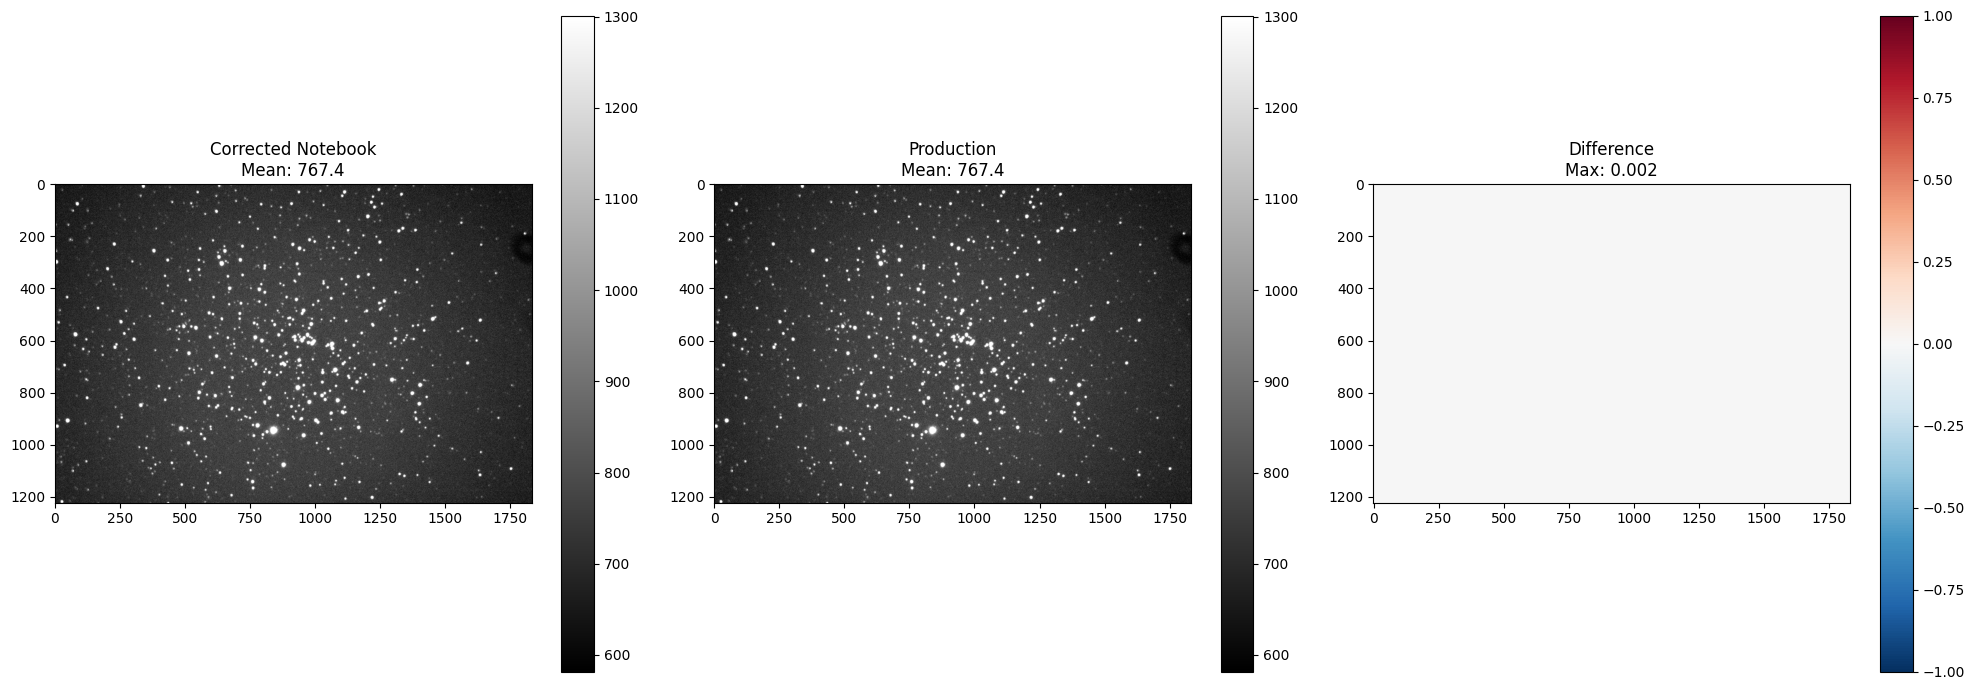

In [ ]:
# CORRECTED NOTEBOOK CALIBRATION WITH DARK SCALING
print("="*60)
print("CORRECTED CALIBRATION (WITH DARK SCALING)")
print("="*60)

# Get exposure times
light_exptime = float(light_header.get('EXPTIME', light_header.get('EXPOSURE', 1.0)))
dark_exptime = float(dark_header.get('EXPTIME', dark_header.get('EXPOSURE', 1.0)))

print(f"Light exposure time: {light_exptime}s")
print(f"Dark exposure time: {dark_exptime}s")

# Step 1: Scale and subtract dark
if abs(dark_exptime - light_exptime) > 0.01:
    scale_factor = light_exptime / dark_exptime
    print(f"Scaling dark by factor: {scale_factor:.6f}")
    dark_scaled = dark_data * scale_factor
else:
    print("No scaling needed (exposure times match)")
    dark_scaled = dark_data

step1_corrected = light_data - dark_scaled

print(f"\nAfter SCALED Dark Subtraction:")
print(f"  Min: {np.min(step1_corrected):.1f}, Max: {np.max(step1_corrected):.1f}")
print(f"  Mean: {np.mean(step1_corrected):.1f}, Median: {np.median(step1_corrected):.1f}")

# Step 2: Normalize flat (same as before)
flat_median = np.median(flat_data)
flat_normalized = flat_data / flat_median
print(f"\nFlat normalized by median: {flat_median:.1f}")

# Step 3: Divide by flat
calibrated_corrected = step1_corrected / flat_normalized

print(f"\nAfter Flat Division (CORRECTED):")
print(f"  Min: {np.min(calibrated_corrected):.1f}, Max: {np.max(calibrated_corrected):.1f}")
print(f"  Mean: {np.mean(calibrated_corrected):.1f}, Median: {np.median(calibrated_corrected):.1f}")

# Compare with production
print("\n" + "="*60)
print("COMPARISON: CORRECTED NOTEBOOK VS PRODUCTION")
print("="*60)
print(f"Corrected notebook mean: {np.mean(calibrated_corrected):.2f}")
if production_calibrated is not None:
    print(f"Production mean: {np.mean(production_calibrated):.2f}")
    print(f"Difference: {np.mean(calibrated_corrected) - np.mean(production_calibrated):.2f}")
    
    # Check if they match now
    diff_corrected = calibrated_corrected.astype(np.float64) - production_calibrated.astype(np.float64)
    max_diff = np.max(np.abs(diff_corrected))
    print(f"Max absolute difference: {max_diff:.6f}")
    
    if max_diff < 0.01:
        print("\n✅✅✅ PERFECT MATCH! Notebook now matches production!")
    elif max_diff < 1.0:
        print(f"\n✅ VERY CLOSE! Only {max_diff:.3f} max difference (likely float32 rounding)")
    else:
        print(f"\n⚠️ Still {max_diff:.1f} difference - other issues remain")
        
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Corrected notebook
im0 = axes[0].imshow(calibrated_corrected, cmap='gray',
                      vmin=np.percentile(calibrated_corrected, 1), 
                      vmax=np.percentile(calibrated_corrected, 99))
axes[0].set_title(f'Corrected Notebook\nMean: {np.mean(calibrated_corrected):.1f}')
plt.colorbar(im0, ax=axes[0])

# Production
if production_calibrated is not None:
    im1 = axes[1].imshow(production_calibrated, cmap='gray',
                          vmin=np.percentile(production_calibrated, 1), 
                          vmax=np.percentile(production_calibrated, 99))
    axes[1].set_title(f'Production\nMean: {np.mean(production_calibrated):.1f}')
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = calibrated_corrected - production_calibrated
    im2 = axes[2].imshow(diff, cmap='RdBu_r', 
                          vmin=-1, vmax=1)
    axes[2].set_title(f'Difference\nMax: {np.max(np.abs(diff)):.3f}')
    plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

DETAILED ANALYSIS

Data types:
  Notebook: float64
  Production: >f4

Detailed statistics:

Notebook calibration:
  Min: 1543.509161
  Max: 63010.266965
  Mean: 1866.449305
  Median: 1836.055670
  Std: 590.430818

Production calibration:
  Min: -1551.969238
  Max: 61943.027344
  Mean: 767.413452
  Median: 737.775330
  Std: 592.600830

Scale ratio (production/notebook): 0.411162
⚠️ There's a -58.88% scaling difference!

After scaling correction:
  Max difference: 87643.230222


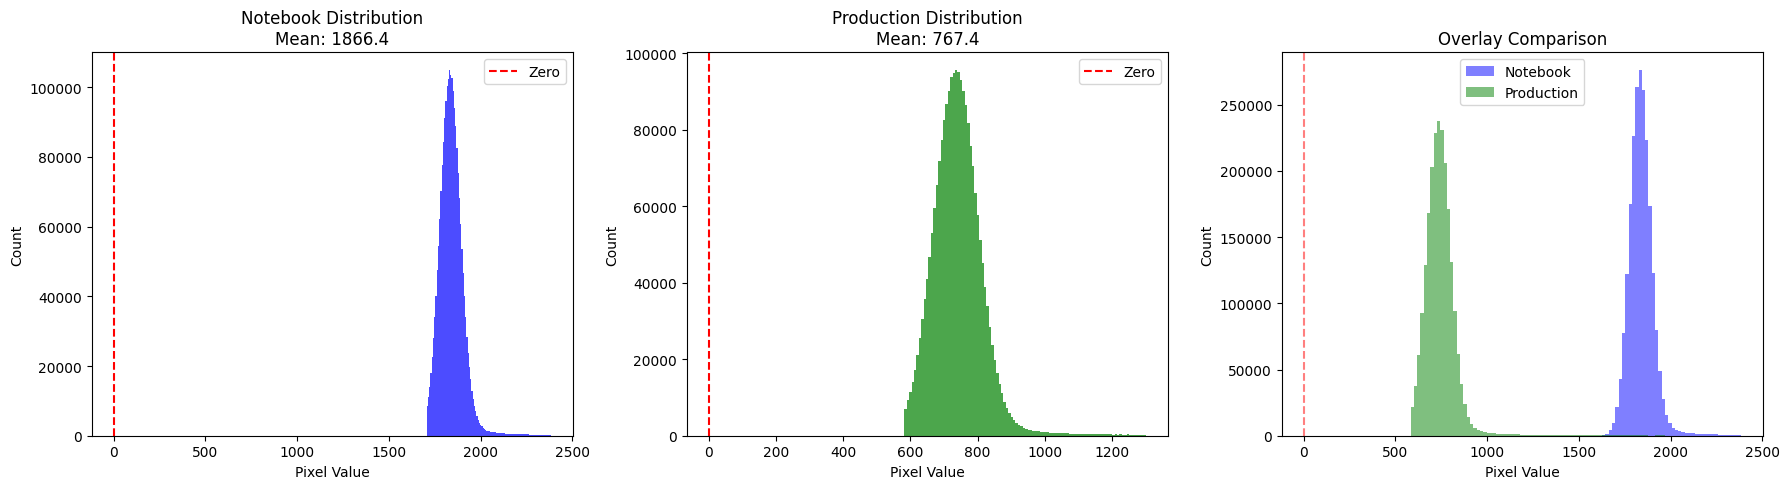

In [ ]:
# Deep dive into the differences
if production_calibrated is not None:
    print("="*60)
    print("DETAILED ANALYSIS")
    print("="*60)
    
    # Check data types
    print(f"\nData types:")
    print(f"  Notebook: {calibrated.dtype}")
    print(f"  Production: {production_calibrated.dtype}")
    
    # Detailed statistics
    print(f"\nDetailed statistics:")
    print(f"\nNotebook calibration:")
    print(f"  Min: {np.min(calibrated):.6f}")
    print(f"  Max: {np.max(calibrated):.6f}")
    print(f"  Mean: {np.mean(calibrated):.6f}")
    print(f"  Median: {np.median(calibrated):.6f}")
    print(f"  Std: {np.std(calibrated):.6f}")
    
    print(f"\nProduction calibration:")
    print(f"  Min: {np.min(production_calibrated):.6f}")
    print(f"  Max: {np.max(production_calibrated):.6f}")
    print(f"  Mean: {np.mean(production_calibrated):.6f}")
    print(f"  Median: {np.median(production_calibrated):.6f}")
    print(f"  Std: {np.std(production_calibrated):.6f}")
    
    # Check if it's a scaling issue
    scale_ratio = np.mean(production_calibrated) / np.mean(calibrated)
    print(f"\nScale ratio (production/notebook): {scale_ratio:.6f}")
    
    if abs(scale_ratio - 1.0) > 0.01:
        print(f"⚠️ There's a {((scale_ratio-1)*100):.2f}% scaling difference!")
        
        # Test if they're proportionally identical
        scaled_production = production_calibrated / scale_ratio
        diff_scaled = scaled_production - calibrated
        max_diff_scaled = np.max(np.abs(diff_scaled))
        print(f"\nAfter scaling correction:")
        print(f"  Max difference: {max_diff_scaled:.6f}")
        if max_diff_scaled < 1.0:
            print("  ✅ Data is proportionally identical - just scaled differently!")
            print(f"  This suggests different flat normalization values are being used.")
    
    # Histogram comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Notebook histogram
    axes[0].hist(calibrated.flatten(), bins=100, alpha=0.7, color='blue', range=(np.percentile(calibrated, 1), np.percentile(calibrated, 99)))
    axes[0].set_title(f'Notebook Distribution\nMean: {np.mean(calibrated):.1f}')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Count')
    axes[0].axvline(0, color='red', linestyle='--', label='Zero')
    axes[0].legend()
    
    # Production histogram
    axes[1].hist(production_calibrated.flatten(), bins=100, alpha=0.7, color='green', range=(np.percentile(production_calibrated, 1), np.percentile(production_calibrated, 99)))
    axes[1].set_title(f'Production Distribution\nMean: {np.mean(production_calibrated):.1f}')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Count')
    axes[1].axvline(0, color='red', linestyle='--', label='Zero')
    axes[1].legend()
    
    # Overlay both
    axes[2].hist(calibrated.flatten(), bins=100, alpha=0.5, color='blue', label='Notebook', range=(min(np.percentile(calibrated, 1), np.percentile(production_calibrated, 1)), max(np.percentile(calibrated, 99), np.percentile(production_calibrated, 99))))
    axes[2].hist(production_calibrated.flatten(), bins=100, alpha=0.5, color='green', label='Production', range=(min(np.percentile(calibrated, 1), np.percentile(production_calibrated, 1)), max(np.percentile(calibrated, 99), np.percentile(production_calibrated, 99))))
    axes[2].set_title('Overlay Comparison')
    axes[2].set_xlabel('Pixel Value')
    axes[2].set_ylabel('Count')
    axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ Cannot analyze - production calibration failed")